In [81]:
import os
import re
import numpy as np
import spacy
import time
import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics
from utils import EmailCleaningService
from transformer import CorExTopicModel

In [82]:
emails_df = pd.read_csv('data/emails_text.csv', index_col=0)

In [83]:
def extract_email_bodies():
    emails_df = pd.read_csv('./data/emails.csv', nrows=10)
    email_parser = email.parser.Parser()
    emails_df.message.apply(lambda x: email_parser.parsestr(x)._payload)
    emails_df = pd.read_csv('./data/emails.csv')
    emails_text = emails_df.message.apply(lambda x: email_parser.parsestr(x)._payload)
    emails_text.to_csv('data/emails_text.csv')
    del emails_df 
    
def remove_email_length_outliers(emails_df):
    Q1 = np.round(emails_df.shape[0]/4)
    Q3 = np.round(3*emails_df.shape[0]/4, 0)
    emails_df['log_len'] = np.log(emails_df['len'])
    emails_df = emails_df.sort_values(by='log_len')
    IQR = emails_df['log_len'].iloc[int(Q3)] - emails_df['log_len'].iloc[int(Q1)]
    lower_bound = emails_df['log_len'].iloc[int(Q1)] - IQR * 1.5
    upper_bound = emails_df['log_len'].iloc[int(Q3)] + IQR * 1.5
    emails_df_filtered = emails_df.loc[(emails_df['log_len']>lower_bound)&(emails_df['log_len']<upper_bound)]
    return emails_df_filtered

In [84]:
emails_sample = emails_df['message'].sample(10000)

In [85]:
cleaned_email_list = []
for i in tqdm.tqdm(range(0, emails_sample.shape[0]//100)):
    cleaned_email_list.append(emails_sample.iloc[i*100:(i+1)*100].apply(EmailCleaningService.instance()))

100%|██████████| 100/100 [06:49<00:00,  4.09s/it]


In [86]:
emails_processed = pd.concat(cleaned_email_list)

In [87]:
os.makedirs('training_data', exist_ok=True)

In [88]:
emails_processed.to_csv('emails_processed.csv')

(array([  48.,   74.,  314., 1006., 2430., 3349., 2115.,  566.,   80.,
          18.]),
 array([ 0.        ,  1.17746588,  2.35493175,  3.53239763,  4.7098635 ,
         5.88732938,  7.06479526,  8.24226113,  9.41972701, 10.59719289,
        11.77465876]),
 <a list of 10 Patch objects>)

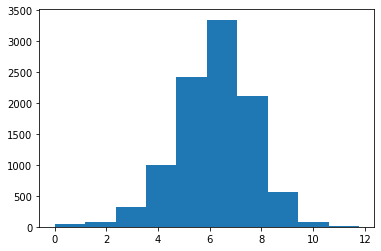

In [89]:
df = pd.read_csv('emails_processed.csv', index_col=0)
df['body'] = df['message']
df['len'] = df['body'].astype(str).apply(len)

plt.hist(np.log(df.len))

{'whiskers': [<matplotlib.lines.Line2D at 0x7fddb8841e80>,
 'caps': [<matplotlib.lines.Line2D at 0x7fddb887c828>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fddb886fe80>],
 'medians': [<matplotlib.lines.Line2D at 0x7fddb887ceb8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fddb8805240>],
 'means': []}

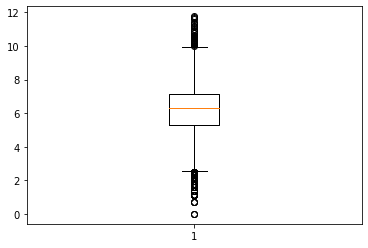

In [90]:
plt.boxplot(np.log(df.len))

In [91]:
no_outliers_df = remove_email_length_outliers(df)
no_outliers_df['random'] = np.random.permutation(no_outliers_df.shape[0])
no_outliers_df = no_outliers_df.sort_values(by='random')

{'whiskers': [<matplotlib.lines.Line2D at 0x7fddb8836668>,
 'caps': [<matplotlib.lines.Line2D at 0x7fddb87d7b70>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fddb87d7358>],
 'medians': [<matplotlib.lines.Line2D at 0x7fddb87e0240>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fddb87e0588>],
 'means': []}

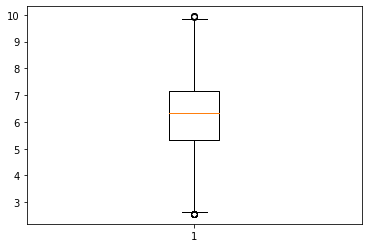

In [92]:
plt.boxplot(np.log(no_outliers_df['len']))

In [93]:
model = CorExTopicModel()
start_time = time.time()
model.train(train.iloc[:10000], n_hidden=20, anchors=[['oil', 'gas', 'energy', 'power', 'kilowatt']], anchor_strength=10)
end_time = time.time()
print(end_time - start_time)

47.584614515304565


In [94]:
model._topic_hash

{0: ['energy',
  'gas',
  'power',
  'oil',
  'natural gas',
  'natural',
  'supply',
  'energy services',
  'marketing',
  'power plant'],
 1: ['market',
  'price',
  'service',
  'costs',
  'prices',
  'cost',
  'change',
  'include',
  'based',
  'value'],
 2: ['let know',
  'let',
  'know',
  'know questions',
  'thanks',
  'know need',
  'know thanks',
  'communicationsenron communications',
  'communicationsenron',
  'enron communicationsenron'],
 3: ['agreement',
  'issues',
  'comments',
  'review',
  'issue',
  'proposed',
  'draft',
  'changes',
  'parties',
  'ferc'],
 4: ['deal',
  'capacity',
  'pipeline',
  'deals',
  'term',
  'plant',
  'mw',
  'purchase',
  'volume',
  'contract'],
 5: ['make',
  'like',
  'way',
  'said',
  'work',
  'want',
  'good',
  'sure',
  'people',
  'say'],
 6: ['news',
  'big',
  'home',
  'rights reserved',
  'reserved',
  'life',
  'game',
  'play',
  'city',
  'act'],
 7: ['houectect',
  'houectect houectect',
  'naenronenron',
  'houeese

In [95]:
model.to_disk()